In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import GridSearchCV
import missingno as mn

from sklearn.impute import SimpleImputer

#### Import Data

In [176]:
data = pd.read_csv('./data/health_insurance_charges.csv', index_col=0)
data

,age,sex,bmi,children,smoker,region,charges
1,18.0,male,33.770,1.0,no,southeast,1725.55230
2,28.0,NaN,33.000,3.0,no,southeast,4449.46200
3,33.0,male,22.705,0.0,no,northwest,21984.47061
5,31.0,female,NaN,0.0,no,southeast,3756.62160
6,46.0,female,33.440,1.0,no,southeast,8240.58960
...,...,...,...,...,...,...,...
1333,50.0,male,30.970,3.0,no,northwest,10600.54830
1334,18.0,female,31.920,0.0,no,northeast,2205.98080
1335,18.0,female,36.850,0.0,no,southeast,1629.83350
1336,21.0,NaN,25.800,0.0,NaN,southwest,2007.94500


#### Find Nulls and overlap in NAs (if any)

<AxesSubplot:>

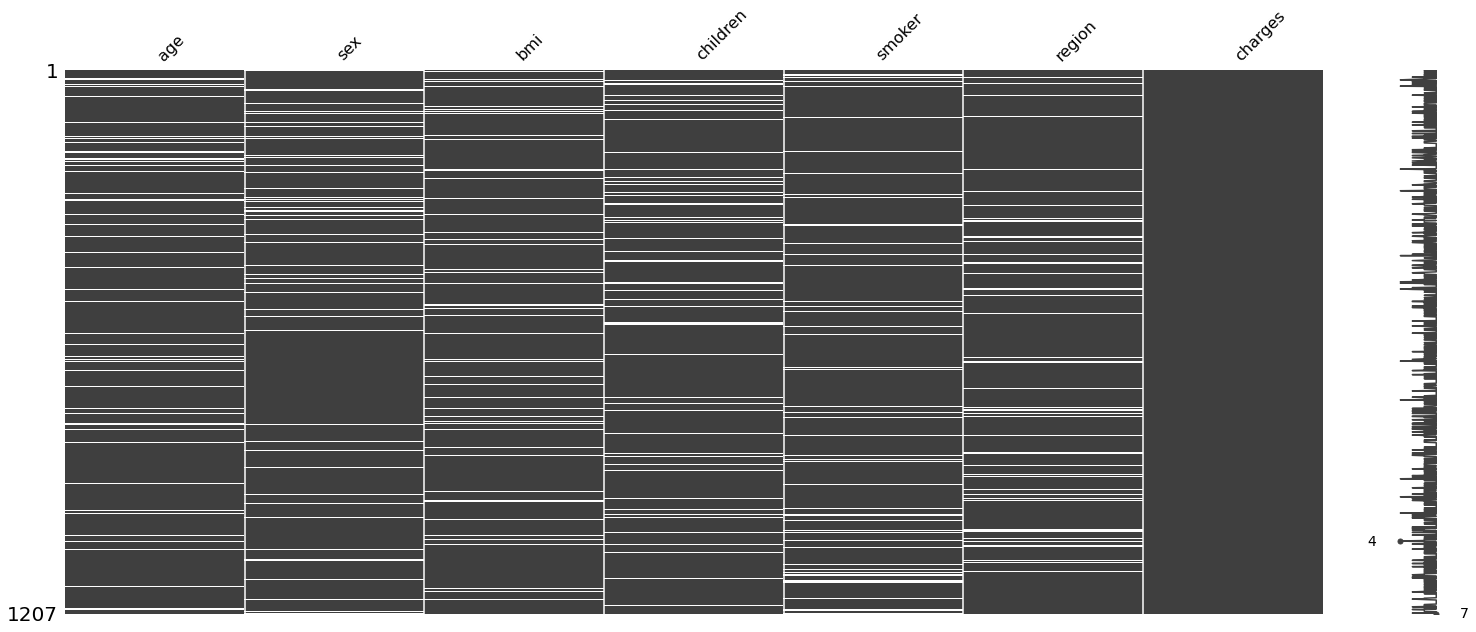

In [177]:
mn.matrix(data)

#### Region is evenly distributed and will not have predicive power

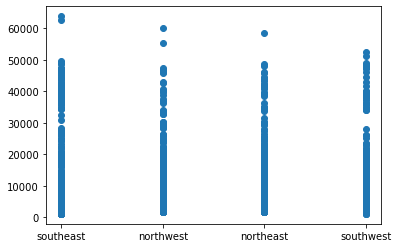

In [178]:
plt.scatter(x=data['region'][data['region'].notna()], y=data['charges'][data['region'].notna()])

#### Split data for cleaning

In [179]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['charges']), data['charges'], random_state=22)

In [180]:
X_training = X_train.copy()
X_testing = X_test.copy()
X_training['charges'] = y_train
X_testing['charges'] = y_test

In [181]:
def clean_X(df):
    
    smoker_means = [.8, .2]
    df['smoker'][df['smoker'].isna()] = df['smoker'][df['smoker'].isna()].map(
    lambda x: np.random.choice([0, 1], p=smoker_means))

    df['smoker'].replace('yes', 1, inplace=True)
    df['smoker'].replace('no', 0, inplace=True)
    

    #binarize and clean sex
    df['sex'][df['sex'].isna()] = df['sex'][df['sex'].isna()].map(lambda x: np.random.randint(0,2))
    df['sex'].replace('male', 1, inplace=True)
    df['sex'].replace('female', 0, inplace=True)

    #set bmi nas to mean
    df['bmi'] = np.where(df['bmi'].isna(), df['bmi'].mean(), df['bmi'])

    #drop region
    df.drop('region', axis=1, inplace=True)

    #format age
    age_means = (df.groupby((df['age']//10)*10).size()/df['age'].notna().sum()).tolist()
    df['age'][df['age'].isna()] = df['age'][df['age'].isna()].map(
    lambda x: np.random.choice([10, 20, 30, 40, 50, 60], p=age_means)
    )

    #children
    df['children'] = np.where(df['children'].isna(), df['children'].mean(), df['children'])

    return df

In [182]:
X_training = clean_X(X_training)
X_training

/var/folders/3y/cshc407d2zv7031zkk2k4r1r0000gn/T/ipykernel_8725/3843279101.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['smoker'][df['smoker'].isna()] = df['smoker'][df['smoker'].isna()].map(
/var/folders/3y/cshc407d2zv7031zkk2k4r1r0000gn/T/ipykernel_8725/3843279101.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sex'][df['sex'].isna()] = df['sex'][df['sex'].isna()].map(lambda x: np.random.randint(0,2))


,age,sex,bmi,children,smoker,charges
176,38.0,1.0,27.835,2.0,0.0,6455.86265
752,64.0,1.0,37.905,0.0,0.0,14210.53595
480,63.0,1.0,41.325,3.0,0.0,15555.18875
1149,42.0,1.0,34.100,0.0,0.0,5979.73100
927,57.0,0.0,20.100,1.0,0.0,12032.32600
...,...,...,...,...,...,...
398,64.0,1.0,25.600,2.0,0.0,14988.43200
1061,57.0,1.0,27.940,1.0,0.0,11554.22360
899,19.0,0.0,22.515,0.0,0.0,2117.33885
146,46.0,1.0,30.495,3.0,1.0,40720.55105


In [183]:
X_training['sex'].value_counts()

1.0    460
0.0    445
Name: sex, dtype: int64

In [184]:
X_training.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
charges     0
dtype: int64

<AxesSubplot:>

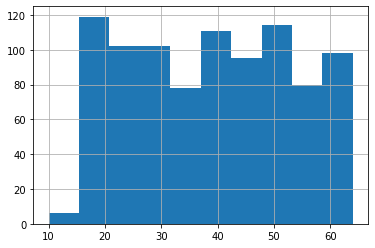

In [185]:
X_training['age'].hist()

#### Inspect relationship between smoking a charges

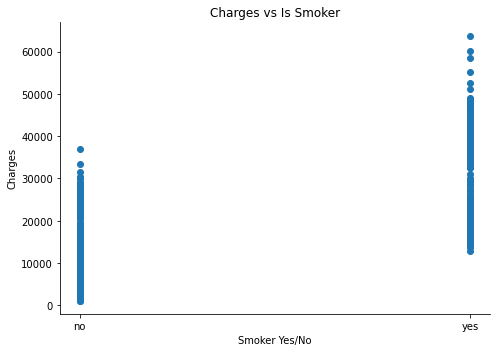

In [186]:
plt.figure(figsize=(7, 5))
plt.scatter(x=data['smoker'][data['smoker'].notna()], y=data['charges'][data['smoker'].notna()])
plt.xlabel("Smoker Yes/No")
plt.ylabel("Charges")
plt.title("Charges vs Is Smoker")
sns.despine()
plt.tight_layout()

#### Drop smoker NAs and binarize

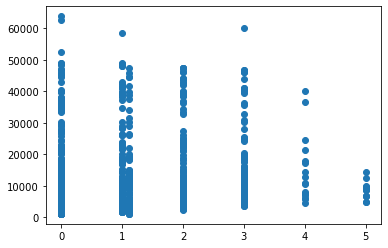

In [187]:
plt.scatter(X_training['children'][X_training['children'].notna()], X_training['charges'][X_training['children'].notna()])

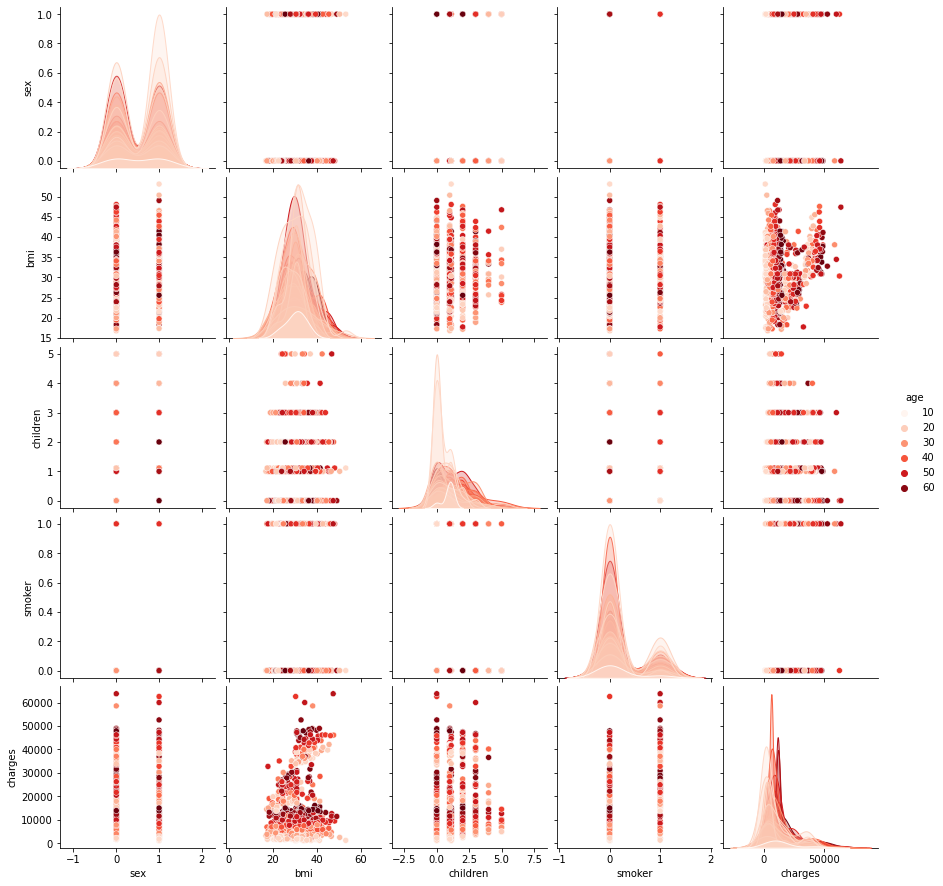

In [188]:
sns.pairplot(X_training, hue='age', palette='Reds')

<AxesSubplot:>

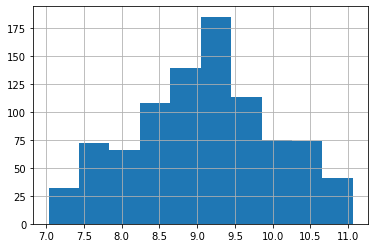

In [189]:
np.log(X_training['charges']).hist()

<AxesSubplot:>

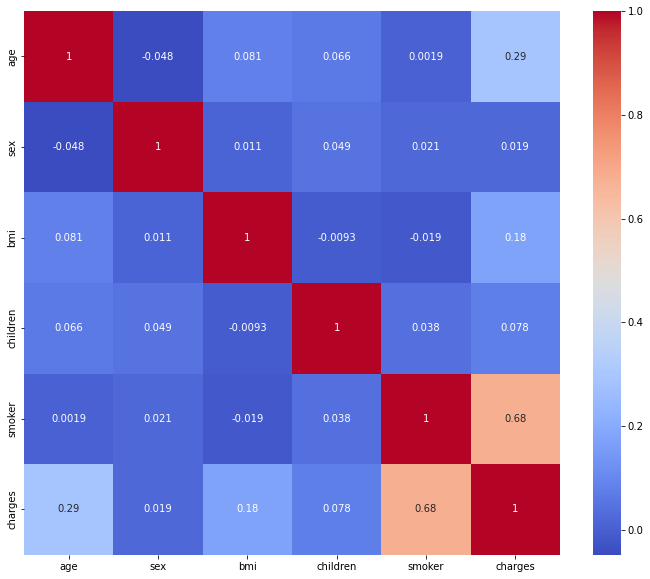

In [190]:
plt.figure(figsize=(12, 10))
sns.heatmap(X_training.corr(), annot=True, cmap='coolwarm')

In [191]:
lr = LinearRegression()

In [192]:
ss = StandardScaler()

In [193]:
poly = PolynomialFeatures(3)

In [194]:
lasso = Lasso()

In [195]:
params = {'lasso__alpha': [40, 50, 100, 200, 300, 400]
            }

In [196]:
piped = make_pipeline(ss, poly, lasso)

In [197]:
gs = GridSearchCV(piped, params)

In [198]:
# X_train, X_test, y_train, y_test = train_test_split(data[['smoker', 'age', 'bmi']], data['charges'], random_state=22)

In [199]:
gs.fit(X_training[['smoker', 'age', 'bmi']], y_train)

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures(degree=3)),
                                       ('lasso', Lasso())]),
             param_grid={'lasso__alpha': [40, 50, 100, 200, 300, 400]})

In [200]:
gs.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('lasso', Lasso(alpha=200))])

In [201]:
X_testing = clean_X(X_testing)

/var/folders/3y/cshc407d2zv7031zkk2k4r1r0000gn/T/ipykernel_8725/3843279101.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['smoker'][df['smoker'].isna()] = df['smoker'][df['smoker'].isna()].map(
/var/folders/3y/cshc407d2zv7031zkk2k4r1r0000gn/T/ipykernel_8725/3843279101.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sex'][df['sex'].isna()] = df['sex'][df['sex'].isna()].map(lambda x: np.random.randint(0,2))


In [202]:
y_pred = gs.predict(X_testing[['smoker', 'age', 'bmi']])

In [204]:
print(gs.score(X_training[['smoker', 'age', 'bmi']], y_train))
print(gs.score(X_testing[['smoker', 'age', 'bmi']], y_test))

0.6412916241360644
0.6648745020265008


In [205]:
mean_squared_error(y_test, y_pred, squared=False)

6894.883282449022

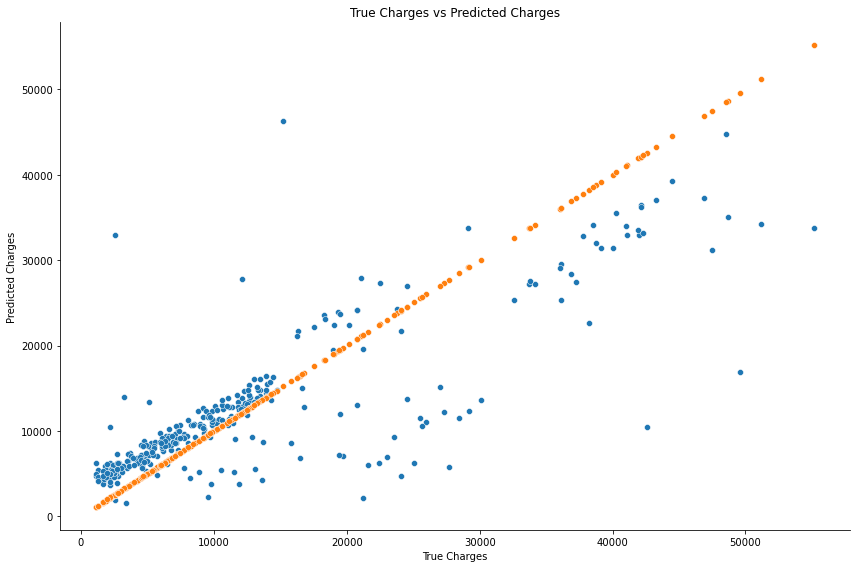

In [206]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=y_test, y=y_pred)
sns.scatterplot(x=y_test, y=y_test)
plt.title("True Charges vs Predicted Charges")
plt.xlabel("True Charges")
plt.ylabel("Predicted Charges")
plt.tight_layout()
sns.despine()

In [207]:
y_null = np.full_like(y_test, X_training['charges'].mean())
gs.score(X_testing[['smoker', 'age', 'bmi']], y_null)
mean_squared_error(y_test, y_null, squared=False)

11912.878922308983

<AxesSubplot:>

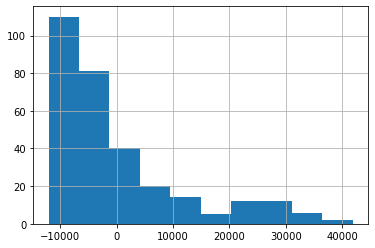

In [208]:
(y_test - y_null).hist()

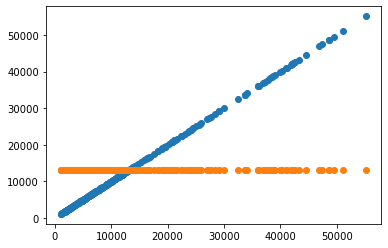

In [209]:
plt.scatter(y_test, y_test)
plt.scatter(y_test, y_null)

In [210]:
poly_names = PolynomialFeatures(3)
poly_names.fit(X_training[['smoker', 'age', 'bmi']])
poly_names.get_feature_names_out()

array(['1', 'smoker', 'age', 'bmi', 'smoker^2', 'smoker age',
       'smoker bmi', 'age^2', 'age bmi', 'bmi^2', 'smoker^3',
       'smoker^2 age', 'smoker^2 bmi', 'smoker age^2', 'smoker age bmi',
       'smoker bmi^2', 'age^3', 'age^2 bmi', 'age bmi^2', 'bmi^3'],
      dtype=object)

In [211]:
pd.DataFrame(data=zip(poly_names.get_feature_names_out(), gs.best_estimator_.named_steps['lasso'].coef_)).sort_values(1)

,0,1
19,bmi^3,-302.124144
15,smoker bmi^2,-114.366781
14,smoker age bmi,0.000000
11,smoker^2 age,-0.000000
18,age bmi^2,0.000000
8,age bmi,0.000000
0,1,0.000000
5,smoker age,-0.000000
4,smoker^2,0.000000
1,smoker,0.000000


In [ ]:
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [ ]:
# Lasso
lasso.fit(pd.DataFrame(X_train_sc, columns=X_train.columns), y_train)

y_pred_lasso = lasso.predict(X_test)

print(lasso.score(X_train_sc, y_train))
print(lasso.score(X_test_sc, y_test))

print(mean_squared_error(y_train, lasso.predict(X_train_sc), squared=False))
print(mean_squared_error(y_test, y_pred_lasso, squared=False))

In [ ]:
# Linear
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)

print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

print(mean_squared_error(y_train, lr.predict(X_train), squared=False))
print(mean_squared_error(y_test, y_preds, squared=False))